In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 23.1MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=b50a4697a352abb42bb9340472c264677c6b0239321ac7bcf9dcb4c2cef6eae8
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=8d2ebf84454be32d8ac553bbafb08d1531f57a667d4b518782ac755e0c05d198
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
!nvidia-smi

Mon Nov 23 11:55:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
import cv2
import sys
import math
import time
from matplotlib import pyplot as plt
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

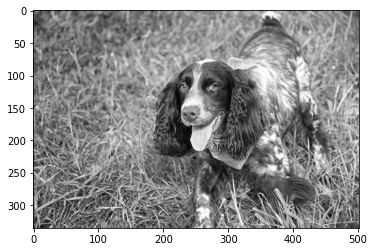

In [6]:
# Подготовка изображение
image1 = cv2.imread('image1.jpg')
cv2.imwrite('image1.bmp', image1)
image2 = cv2.imread('/content/image1.bmp')
gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
replicate = cv2.copyMakeBorder(gray,1,1,1,1,cv2.BORDER_REPLICATE)
cv2.imwrite('replicate.bmp', replicate)
N, M = replicate.shape[0], replicate.shape[1]
sigma_r, sigma_d = 200, 200
block_size=(16,16,1)
grid_size=(N//block_size[0] + 1, M//block_size[1] + 1)
plt.imshow(replicate, 'gray')

###Bilateral filter CPU

In [9]:
# g(x, y)
def g_func(x, y, sigma_d):
  return math.exp(-((x**2-y**2)/(sigma_d**2)))

# r(a_i)
def r_func(f_i, f_0, sigma_r):
  return math.exp(((int(f_i)-int(f_0))**2)/(sigma_r**2))

def bilateralFilterCPU(image, diameter, sigma_r, sigma_d):
  result_image = np.zeros(image.shape)
  r = diameter//2
  for i in range(1, len(image)-1):
    for j in range(1, len(image[0])-1):
      h = 0
      k = 0
      for i_k in range(i-r, i+r+1):
        for j_k in range(j-r, j+r+1):
          x = i_k - i
          y = j_k - j
          w = g_func(x, y, sigma_d) * r_func(image[i_k][j_k], image[i][j], sigma_r)
          h += image[i_k][j_k]*w
          k += w
      result_image[i][j] = h/k
  return result_image

Время работы последовательного алгоритма: 7.981761932373047 с.


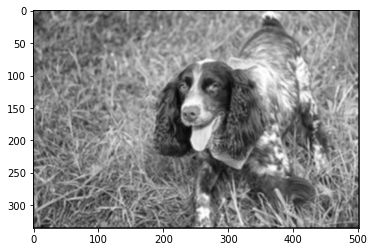

In [10]:
start_time_cpu = time.time()
filtered_image_cpu = bilateralFilterCPU(replicate, 3, sigma_r, sigma_d)
end_time_cpu = time.time() - start_time_cpu
cv2.imwrite('result_image_cpu.bmp', filtered_image_cpu)
print(f"Время работы последовательного алгоритма: {end_time_cpu} с.")
plt.imshow(filtered_image_cpu, 'gray')

###Bilateral filter GPU

In [12]:
# считываем файл kernel.cu
with open("kernel.cu", "r") as file_cuda:
  kernel = file_cuda.read()
  file_cuda.close()
  mod = SourceModule(kernel)

Время работы параллельного алгоритма: 0.014425516128540039 с.


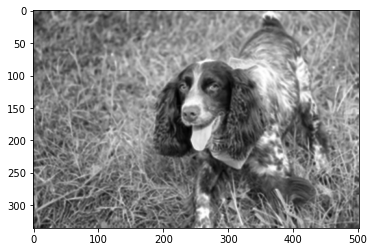

In [13]:
filtered_image_gpu = np.zeros((N, M), dtype = np.uint8)

bilateralFilterGPU = mod.get_function("bilateralFilterGPU")
tex_image = mod.get_texref("tex_image")
drv.matrix_to_texref(replicate.astype(np.uint32), tex_image, order="C")
start_time_gpu = time.time()
bilateralFilterGPU(drv.Out(filtered_image_gpu), np.int32(N), np.int32(M), np.float32(sigma_r), np.float32(sigma_d), block=block_size, grid=grid_size, texrefs=[tex_image])
drv.Context.synchronize()
end_time_gpu = time.time() - start_time_gpu

cv2.imwrite('result_image_gpu.bmp', filtered_image_gpu)
print(f"Время работы параллельного алгоритма: {end_time_gpu} с.")
plt.imshow(filtered_image_gpu, 'gray')

### Ускорение алгоритма на CUDA

In [14]:
S = end_time_cpu/end_time_gpu
print(f"Ускорение: {S}")

Ускорение: 553.3085860672671
